In [1]:
import numpy as np

# Basic expansion in base b

this code works for integers

In [2]:
def int2base(x, b=2):  
    digits = []
    while x > 0:
        digits.append(x % b)
        x //= b
    return list(reversed(digits))


# Expansions for fractions p/q

In [765]:
def digits(p,q,
           b=2, num_digits=20):
    
    if (p > q): raise ValueError
    r = p
    digits = []
    for _ in range(num_digits):
        digits.append( (r*b) // q)
        r = (r*b) % q
    return digits

In [767]:
digits(1,6)

[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

---

## More sophistocated

This returns the **full** expansion in base ```b``` in 2 parts
1. an initial sequence of digits  which isn't repeated
1. the repeating part

---

### Examples

1/6 = 0.166666666

- starts with 1
- the repeating part is 6

$\frac16 = \frac{1}{10}  +  \frac{1}{10} \times \frac{6}{9}$ 

and form the binary expansion of $1/10$

- starts with 0
- the repeating part is 0011

$\frac{1}{10}   =  \frac{1}{2} \times  \left( 3  \times  \frac{1/16}{1- 1/16} \right)$ 

In [1]:
def digits(p,q,
           b=2,n=20):
    r = p
    pos = {p : 0}
    digits = []
    
    while True:
        p, r = (r*b) // q, (r*b) % q
        digits.append(p)
        # this is a trick, stop if it repeats
        if r in pos: break
        pos[r] = len(digits)
    
    return digits[:pos[r]], digits[pos[r]:]

In [4]:
digits(1,10,b=2)

([0], [0, 0, 1, 1])

In [307]:
digits(1,13,b=2)

([], [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1])

---

# Euler's constant


You should read the [wikipedia page](https://en.wikipedia.org/wiki/Euler%27s_constant)

I'll use **numpy** to do this without writing a ```for``` loop


In [5]:
np.arange(1,101)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

---

The ```for``` loop is to study the convergence over bigger and bigger ranges

Convergence is very very slow

-  because $1/n - (\log(n+1) -\log(n)) \rightarrow 0$ very slowly $O(1/n^2)$
- $2^{-n} \rightarrow 0$ much more quickly

In [6]:
[sum(1./np.arange(1,k)) - np.log(k) for k in range(1000,10000,1000)]

[0.5767155815682061,
 0.576965644068201,
 0.577048988975589,
 0.5770906596931713,
 0.5771156615681665,
 0.5771323292533648,
 0.5771442346293849,
 0.5771531635994176,
 0.577160108317134]

[euler's constant](https://en.wikipedia.org/wiki/Euler%27s_constant)

0.5772156649

---

## This is purely for amusement

speed test

- a **pure** Python function 
- Python compiled to C using Cython
- a **one liner** in numpy


---

## Pure Python 

I saw someone write this and it's correct

In [7]:
def harmonic_py(n):
    s = 0 
    for i in range(1, n+1):
        s += 1.0/i
    return s

there's a trick to cross compile this to C 

- add typing
- this should be [easier](https://docs.python.org/3/library/typing.html) but :( apparently only for linters

In [9]:
%load_ext Cython

In [101]:
%%cython 

import cython

# I think this turns off a division by zero check 
@cython.cdivision(True)
def harmonic(int n):
    cdef int i 
    # careful you need to use double not float here
    cdef double s = 0
    for i in range(1, n+1):
        s += 1.0/i
    return s

if you don't use **double** then things are pretty bad
because of rounding errors

In [11]:
harmonic(5), (1./np.arange(1,6)).sum()

(2.283333333333333, 2.283333333333333)

In [390]:
harmonic(5), (1./np.arange(1,6)).sum()

(2.283333333333333, 2.283333333333333)

but **double** is just fine 

In [13]:
#fails at 10**10

k = 10**9
harmonic(k) - np.log(k) - 0.5772156649

5.021394411386382e-10

## Much slower

but in practice this is good for understanding cases

In [769]:
k = 100000
sum(1./np.arange(1,k)) - np.log(k)

0.5772106648931068

## Comparison

In [98]:
k = 100000

In [132]:
%%timeit

harmonic(k) - np.log(k)

128 µs ± 3.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
(1./np.arange(1,k)).sum() - np.log(k)

599 µs ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit

harmonic_py(k) - np.log(k)

6.86 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

## Horner

- P a list of coefficients to of a polynomial to be evaluated in
- x a floating point

Note that ```P[0]``` is the constant term so we need to reverse the order in the list 
when applying Horner.

There are 2 arithemetic operations per loop
```
        val *= x
        val += coeff
```
and the loop is executed ```len(P)``` times 
so the algorithm is linear in the degree of ```P```.

---

I usually use something like this to evaluate

``` sum ([x**i * coeff for i,coeff in enumerate(P)])```

- ```x**i * coeff``` is i multiplications
- there are ```len(P)``` - 1 additions in the ```sum()```

so this is quadratic in the degree of ```P```.

Technically this uses more memory than a ```for``` loop.


In [884]:
def horner_py(x, P):
    val = 0
    for coeff in reversed(P):
        val *= x
        val += coeff
        
    return val

---

Timing things doesn't really make good sense
as there are all sorts of things that can happen
during between different executions of the function.

In [771]:
import time

In [853]:
def naif_eval(x,P):
    val = 0
    for i, coeff in enumerate(P):
        val += coeff*x**i
    return val
    

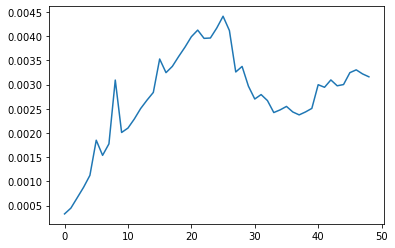

In [894]:
P = np.arange(2000)
T = []

for n in range(0,1000,20):
    naif_eval(1.01, P[:n])
    T.append(time.time())

# this calculates differences between consecutive elements in T[]
plt.plot(np.diff(T,1));

In [851]:
horner_py(.9,P[:70])

9.993734212517824

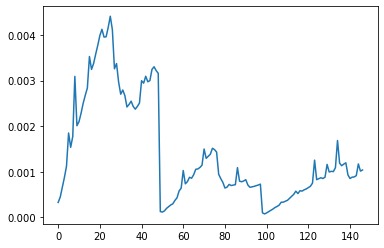

In [896]:
P = np.arange(2000)

for n in range(0,1000,20):
    horner_py(1.1,P[:n])
    T.append(time.time())

ts = np.diff(T,1)
plt.plot(ts[ts<.1][:]);

In [898]:
horner_py(1.1,P), naif_eval(1.1,P)

(1.2134030984085583e+87, 1.2134030984085563e+87)

---

I do sometimes compile Python to C using [Cython](https://cython.org/)
and then comparing speeds between different implementations does make sense.

In [768]:
%%cython

import cython

def horner(double x, list P):
    cdef double val = 0
    for coeff in reversed(P):
        val *= x
        val += coeff
        
    return val

In [85]:
P = [1]*500
horner(.9,P), sum([.9**i * coeff for i, coeff in enumerate(P)])

(9.999999999999995, 9.999999999999993)

In [86]:
%%timeit 
horner(.9,P)

17.9 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [87]:
%%timeit 
horner_py(.9,P)

30.1 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
%%timeit 
np.array(P).dot(np.array([.9**i for i in range(len(P))]))

3.99 µs ± 168 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [88]:
%%timeit 
sum ([.9**i * coeff for i, coeff in enumerate(P)])

85.6 µs ± 4.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [92]:
def ev(x,P):
    s = 0 
    for i,c in enumerate(P):
        s += c*x**i
    return s

ev(.9,P), horner(.9,P)

(9.999999999999993, 9.999999999999995)

In [91]:
%%timeit 
ev(.9,P)

85 µs ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [127]:
%%cython 

import cython
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)

def n2b(int x, int b=2):  
    cdef list digits = []
    
    while x > 0:
        digits.append(x % b)
        x //= b
    return list(reversed(digits))


In [124]:
%%cython

import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)

def n2b(int x, int b=2):  
    cdef np.ndarray digits = np.zeros(20, dtype=int)
    
    cdef int i = 19
    while x > 0:
        digits[i] = x % b
        i -= 1
        x //= b
    return digits[i:]
